# Heterogenous Modelling
Using different kinds of distributions to model data, instead of only a single kind of distribution.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

import sys
sys.path.append('../')
import utils as utl
import datasets as d
import models as m

tfd = tfp.distributions
tfm = tf.math

%load_ext autoreload
%autoreload 2

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\sap98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Define Model

In [3]:
# Number of components per distribution
K = 10

In [4]:
# Define a distribution for each dimension of the data
dists = [
    tfd.Normal, # dimension 1
    tfd.Normal  # dimension 2
]

In [5]:
# Define the parameters used by the model
params = [
    # distribution 1
    [
        np.random.uniform(-4, 4, (K, K)),
        np.random.uniform(0, 4, (K, K))
    ],
    # distribution 2
    [
        np.random.uniform(-4, 4, (K, K)),
        np.random.uniform(0, 4, (K, K))
    ]
]

In [6]:
# Define the modifyer used for each dimension
# set to None for categorical
modifiers = {
    0: {1: tfm.softplus},
    1: {1: tfm.softplus}
}

In [7]:
# Instantiate models
TT_gen = m.TensorTrainGeneral(K, dists, params, modifiers)
TT_fix = m.TensorTrainGaussian(K, 2)

## Get Toy Data

In [8]:
# print different options
d.get_toy_names()

['8gaussians',
 'swissroll',
 'circles',
 'rings',
 'moons',
 'pinwheel',
 '2spirals',
 'checkerboard',
 'line',
 'cos']

In [9]:
# Define number of datapoints
N = 10000
name = 'checkerboard'

In [10]:
# generate data
data = d.get_ffjord_data(name, batch_size=N)

In [11]:
# Split into train, validation and test set
train, val, test = d.split_data(data)

In [12]:
# convert training data to TF batched dataset
batch_size = 100
train_ds = d.to_tf_dataset(train, batch_size=batch_size)

## Fit models to data

In [13]:
# Define number of epochs to train on
EPOCHS = 500

In [14]:
# Training optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [15]:
# train TT general version
losses_gen = TT_gen.fit(train_ds, EPOCHS, optimizer)

Training TT: 100%|██████████| 500/500 [00:52<00:00,  9.47it/s]Training time elapsed: 52 seconds
Final loss: 3.507068634033203



In [16]:
# train TT fixed gaussian version 
losses_fix = TT_fix.fit(train_ds, EPOCHS, optimizer)

Training TT: 100%|██████████| 500/500 [00:50<00:00,  9.88it/s]Training time elapsed: 50 seconds
Final loss: 3.4959461212158205



## Display Results

In [17]:
# check integrand of density
integrand = utl.unitTest(TT_gen, limits=[-6, 6])
print(f'Density integrates to {round(integrand, 4)}')
print('It should be = 1.0')

Density integrates to 1.0
It should be = 1.0


GENERAL TT MODEL


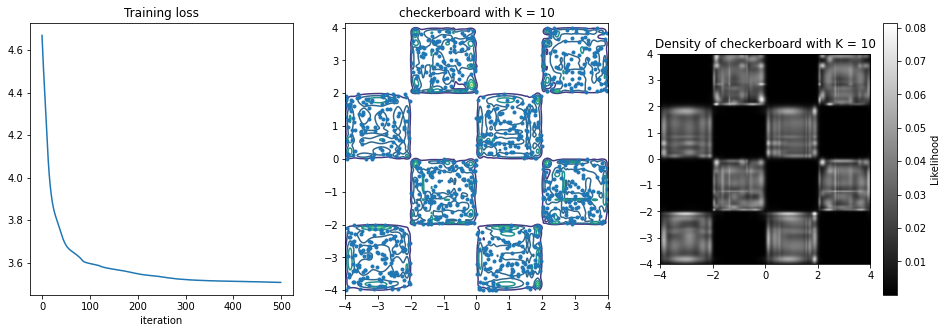

In [18]:
# plots for the general TT model
print("GENERAL TT MODEL")
f, ax = plt.subplots(1, 3, figsize=(16, 5))

# training loss
ax[0].plot(range(len(losses_gen)), np.array(losses_gen))
ax[0].set_title('Training loss')
ax[0].set_xlabel('iteration')

# contour plot
utl.plot_contours(ax[1], val, TT_gen, alpha=1)
ax[1].set_title(name + ' with K = '+str(K))

# density plot
utl.plot_density(ax[2], TT_gen)
ax[2].set_title('Density of ' + name + ' with K = ' + str(K))
plt.show()

FIXED TT MODEL


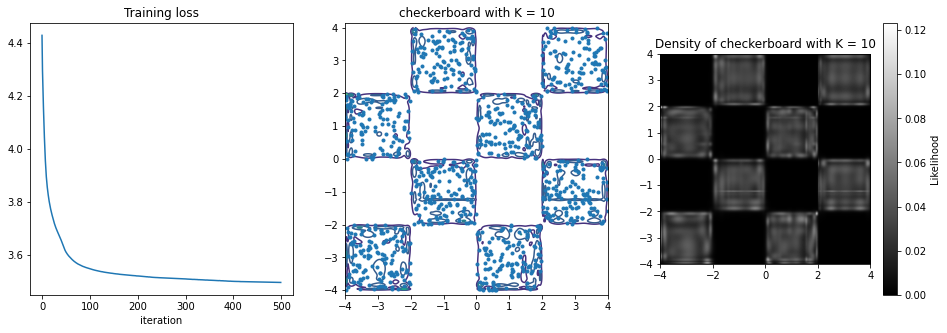

In [19]:
# plots for the fixed TT gaussian model
print("FIXED TT MODEL")
f,ax = plt.subplots(1, 3, figsize=(16, 5))

# training loss
ax[0].plot(range(len(losses_fix)), np.array(losses_fix))
ax[0].set_title('Training loss')
ax[0].set_xlabel('iteration')

# contour plot
utl.plot_contours(ax[1], val, TT_fix, alpha=1)
ax[1].set_title(name + ' with K = '+str(K))

# density plot
utl.plot_density(ax[2], TT_fix)
ax[2].set_title('Density of ' + name + ' with K = ' + str(K))
plt.show()